In [357]:
# 1) Imports
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns


In [358]:
df = pd.read_csv(r"C:\Users\Alekhya\Downloads\titanic (1).csv")


In [359]:
# 2) Load your provided CSV (exact headers used)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)


Shape: (887, 8)
Columns: ['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard', 'Parents/Children Aboard', 'Fare']


,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250


In [360]:
# 3) Rename columns to standard names the pipeline will expect
df = df.rename(columns={
    "Siblings/Spouses Aboard": "SibSp",
    "Parents/Children Aboard": "Parch"
})

# Confirm renamed columns
print(df.columns.tolist())


['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']


In [361]:
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Fare"] = df["Fare"].fillna(df["Fare"].median())


In [362]:
# 5) Feature engineering (task suggests FamilySize, IsAlone, Title) 
# Title extraction from Name (Mr., Mrs., Miss., Master., etc.)
df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)

# FamilySize = SibSp + Parch + 1
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

# IsAlone = 1 if FamilySize == 1 else 0
df["IsAlone"] = (df["FamilySize"] == 1).astype(int)


In [363]:
# 6) Select features and target
target = "Survived"
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "FamilySize", "IsAlone", "Title"]

X = df[features].copy()
y = df[target].astype(int)


In [364]:
# 7) Identify categorical vs numerical columns (Embarked not present in your file)
categorical_features = ["Sex", "Title"]
numerical_features = ["Pclass", "Age", "SibSp", "Parch", "Fare", "FamilySize", "IsAlone"]


In [365]:
# 8) Preprocessing pipeline (OneHot for categoricals, Scale numericals)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)


In [366]:
# 8) Preprocessing pipeline (OneHot for categoricals, Scale numericals)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)


In [367]:
# 9) Train/test split (stratify on y to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (709, 9) Test size: (178, 9)


In [368]:
# 10) Define and train two models via Pipelines
models = {
    "Logistic Regression": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
    ])
}

results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    results[name] = {"Accuracy": acc, "F1": f1, "Precision": prec, "Recall": rec}
    print(f"\n{name} Performance")
    print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")
    print(classification_report(y_test, y_pred))



Logistic Regression Performance
Accuracy: 0.8034 | F1: 0.7328 | Precision: 0.7742 | Recall: 0.6957
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       109
           1       0.77      0.70      0.73        69

    accuracy                           0.80       178
   macro avg       0.80      0.78      0.79       178
weighted avg       0.80      0.80      0.80       178


Random Forest Performance
Accuracy: 0.7584 | F1: 0.6906 | Precision: 0.6857 | Recall: 0.6957
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       109
           1       0.69      0.70      0.69        69

    accuracy                           0.76       178
   macro avg       0.75      0.75      0.75       178
weighted avg       0.76      0.76      0.76       178



In [369]:
# 11) Compare model performance as a small DataFrame
perf_df = pd.DataFrame(results).T.sort_values("Accuracy", ascending=False)
print("\nModel Performance Comparison:\n", perf_df)



Model Performance Comparison:
                      Accuracy        F1  Precision    Recall
Logistic Regression  0.803371  0.732824   0.774194  0.695652
Random Forest        0.758427  0.690647   0.685714  0.695652


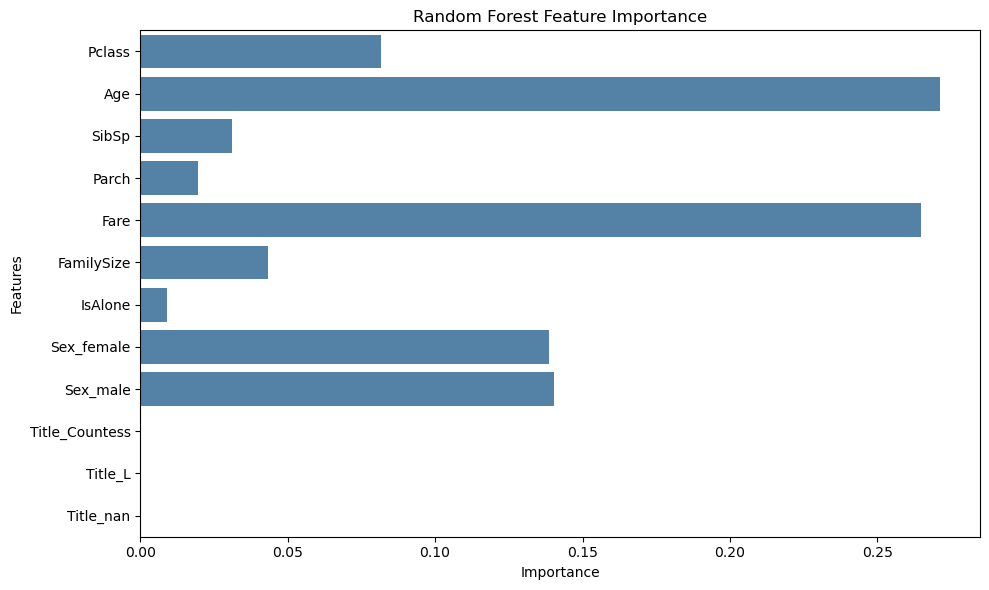

In [370]:
# 12) Feature importance (Random Forest) mapped back to feature names
rf = models["Random Forest"]
rf.fit(X_train, y_train)

# Get feature names after preprocessing
cat_ohe = rf.named_steps["preprocessor"].named_transformers_["cat"]
cat_feature_names = list(cat_ohe.get_feature_names_out(categorical_features))
final_feature_names = numerical_features + cat_feature_names

importances = rf.named_steps["classifier"].feature_importances_

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=final_feature_names, orient="h", color="steelblue")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


In [371]:
# 13) Simple insights printout
top_feats = pd.Series(importances, index=final_feature_names).sort_values(ascending=False).head(8)
print("\nTop predictive features:\n", top_feats)

# Business-style summary
best_model = perf_df.index[0]
print(f"\nSummary:")
print(f"- Best model: {best_model}")
print(f"- Accuracy: {perf_df.loc[best_model, 'Accuracy']:.3f}, F1: {perf_df.loc[best_model, 'F1']:.3f}")
print("- Strong predictors typically include passenger class, gender (Sex), and fare.")
print("- FamilySize/IsAlone helps capture group travel effects.")



Top predictive features:
 Age           0.271238
Fare          0.264850
Sex_male      0.140310
Sex_female    0.138666
Pclass        0.081773
FamilySize    0.043356
SibSp         0.031121
Parch         0.019533
dtype: float64

Summary:
- Best model: Logistic Regression
- Accuracy: 0.803, F1: 0.733
- Strong predictors typically include passenger class, gender (Sex), and fare.
- FamilySize/IsAlone helps capture group travel effects.


In [372]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns


In [373]:
import pandas as pd

housing = pd.read_csv(r"https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv")
print(housing.shape)
print(housing.head())


(20640, 10)
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


In [374]:
# Drop rows with missing values
housing = housing.dropna()

# Features and target
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

# Separate categorical vs numerical
categorical_features = ["ocean_proximity"]
numerical_features = [col for col in X.columns if col not in categorical_features]


In [375]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


In [376]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (16346, 9) Test size: (4087, 9)


In [377]:
models = {
    "Linear Regression": Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression())
    ]),
    "Random Forest Regressor": Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=200, random_state=42))
    ])
}


In [378]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"RMSE": rmse, "R2": r2}
    print(f"\n{name} Performance:")
    print(f"RMSE: {rmse:,.0f} | R²: {r2:.4f}")



Linear Regression Performance:
RMSE: 69,298 | R²: 0.6488

Random Forest Regressor Performance:
RMSE: 48,714 | R²: 0.8265


In [379]:
perf_df = pd.DataFrame(results).T.sort_values("RMSE")
print("\nModel Performance Comparison:\n", perf_df)



Model Performance Comparison:
                                  RMSE        R2
Random Forest Regressor  48714.273863  0.826468
Linear Regression        69297.716691  0.648840


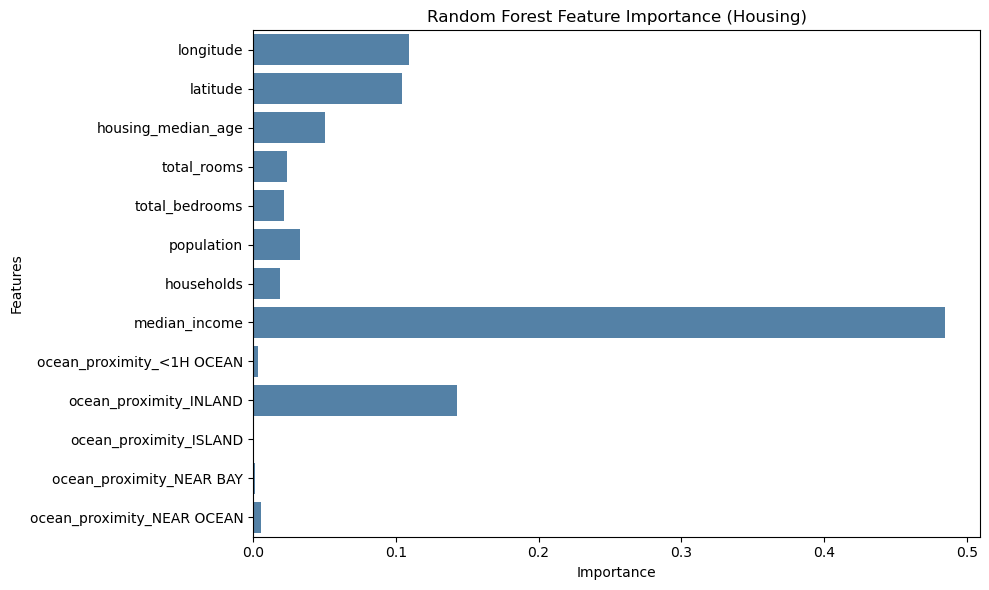

In [380]:
rf = models["Random Forest Regressor"]
rf.fit(X_train, y_train)

# Get feature names after preprocessing
cat_ohe = rf.named_steps["preprocessor"].named_transformers_["cat"]
cat_feature_names = list(cat_ohe.get_feature_names_out(categorical_features))
final_feature_names = numerical_features + cat_feature_names

importances = rf.named_steps["regressor"].feature_importances_

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=final_feature_names, orient="h", color="steelblue")
plt.title("Random Forest Feature Importance (Housing)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()
